# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['filename'] = name
    return result

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = read_result(name)
    result['platform'] = get_platform(name)
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    result['stochastic_network'] = install_options['stochastic_network']
    repositories = info['git_repositories']
    repo = [r for r in repositories if r['path'] == 'hpl-2.2']
    assert len(repo) == 1
    hpl_hash = repo[0]['hash']
    if hpl_hash == '4ba643763846acfc5c74a3d3cfd3ac68b6f06704':
        result['heterogeneous_dgemm'] = False
    else:
        result['heterogeneous_dgemm'] = install_options['heterogeneous_dgemm']
    return result

simulation_directories = ['paper_sc19/performance/2/', 'paper_sc19/performance/10/']
simulation_files = [d + f for d in simulation_directories for f in os.listdir(d)]

reality_files = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
    '../hpl/grenoble_2019-03-15_1855885.zip',
    '../hpl/grenoble_2019-03-18_1856059.zip',
]
dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfreal = pandas.concat([read_result(f) for f in reality_files])
dfsim['mode'] = 'simulation'
dfreal['mode'] = 'reality'
dfreal['date'] = dfreal['filename'].str[16:23]

dfsim = dfsim.reset_index(drop=True)
dfsim.loc[dfsim['heterogeneous_dgemm'] == True, 'model'] = dfsim['model'] + '_het'
df = pandas.concat([dfsim, dfreal])

Dumping to a CSV file.

In [2]:
# Dumping to CSV
csv_columns = ['matrix_size', 'gflops', 'time', 'mode']
csv_simu_columns = csv_columns + ['stochastic_cpu', 'stochastic_network', 'polynomial_dgemm', 'heterogeneous_dgemm']
csv_real_columns = csv_columns + ['date']
dfreal[csv_real_columns].to_csv('/tmp/hpl_reality.csv', index=False)
dfsim[~dfsim.heterogeneous_dgemm][csv_simu_columns].to_csv('/tmp/hpl_simulation_homogeneous.csv', index=False)
dfsim[dfsim.heterogeneous_dgemm][csv_simu_columns].to_csv('/tmp/hpl_simulation_heterogeneous.csv', index=False)

In [3]:
dfreal = dfreal[dfreal.date == '2019-03']  # keeping only the most recent executions

sizes = set(dfsim[dfsim.heterogeneous_dgemm].matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
dfsim = dfsim[dfsim.matrix_size.isin(sizes)]
dfreal = dfreal[dfreal.matrix_size.isin(sizes)]

df.head()

,application_time,bcast,block_size,cpu_utilization,date,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,...,residual,rfact,simulation_time,stochastic_cpu,stochastic_network,swap,sys_time,thread_per_process,time,usr_time
1,145.489,2,128,1.00,NaN,1,42.0,42.0,42.0,42.0,...,NaN,2,1090.24,False,False,0,73.38,1,5.95,1017.62
2,868.582,2,128,0.99,NaN,1,42.0,42.0,42.0,42.0,...,NaN,2,8401.72,False,False,0,1449.71,1,667.07,6950.00
5,570.477,2,128,0.99,NaN,1,42.0,42.0,42.0,42.0,...,NaN,2,5131.18,False,False,0,748.48,1,214.99,4381.29
6,272.380,2,128,0.99,NaN,1,42.0,42.0,42.0,42.0,...,NaN,2,2270.99,False,False,0,224.30,1,33.67,2046.24
14,209.723,2,128,0.99,NaN,1,42.0,42.0,42.0,42.0,...,NaN,2,1652.77,True,True,0,115.74,1,5.84,1537.06


### Checking the parameters

In [4]:
dfsim[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
1,42.0,42.0,42.0,42.0


In [5]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'platform', 'model', 'stochastic_dgemm', 'heterogeneous_dgemm',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode', 'filename', 'date'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,thread_per_process,swap,pfact,rfact,proc_q,bcast,proc_p,depth,block_size,process_per_node,mem_align
1,1,0,1,2,32,2,32,1,128,32,8


In [6]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files] # I changed the platform in this new simulation, calls to SMPI_Wtime now do not take time
# platforms = [zipfile.ZipFile(f).read('dahu.xml').decode('ascii') for f in (simulation_files + simulation_files_old)]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [7]:
patches = {}
for archive in simulation_files:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    install_options = get_yaml(archive, installfile)
    stochastic_cpu = install_options['stochastic_cpu']
    polynomial_dgemm = install_options['polynomial_dgemm']
    try:
        heterogeneous_dgemm = install_options['heterogeneous_dgemm']
    except KeyError:
        heterogeneous_dgemm = False
    repos = get_yaml(archive, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    try:
        patches[(stochastic_cpu, polynomial_dgemm, heterogeneous_dgemm)].add((hpl[0]['patch'], hpl[0]['hash']))
    except KeyError:
        patches[(stochastic_cpu, polynomial_dgemm, heterogeneous_dgemm)] = {(hpl[0]['patch'], hpl[0]['hash'])}
for (stochastic_cpu, polynomial_dgemm, heterogeneous_dgemm), patch in patches.items():
    assert len(patch) == 1
    patch, commit_hash = patch.pop()
    display(Markdown('### stochastic_cpu=%s  |  polynomial_dgemm=%s | heterogeneous_dgemm=%s' % (stochastic_cpu, polynomial_dgemm, heterogeneous_dgemm)))
    display(Markdown(commit_hash))
    display(Markdown('```diff\n%s\n```' % patch))

### stochastic_cpu=False  |  polynomial_dgemm=True | heterogeneous_dgemm=False

4ba643763846acfc5c74a3d3cfd3ac68b6f06704

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index 0119820..dfe826c 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -144,6 +144,7 @@ double random_halfnormal(void) {
 double random_halfnormal_shifted(double exp, double std) {
     // Here, exp and std are the desired expectation and standard deviation.
     // We compute the corresponding mu and sigma parameters for the normal distribution.
+    return exp;
     double mu, sigma;
     sigma = std/sqrt(1-2/M_PI);
     mu = exp - sigma*sqrt(2/M_PI);
    
```

### stochastic_cpu=True  |  polynomial_dgemm=False | heterogeneous_dgemm=False

4ba643763846acfc5c74a3d3cfd3ac68b6f06704

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index 35dea84..3803d8c 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -214,7 +214,7 @@ static double dtrsm_intercept = -1;
     double mn =  (double)(M) * (double)(N);\
     double mk =  (double)(M) * (double)(K);\
     double nk =  (double)(N) * (double)(K);\
-    double raw_duration = 2.844700e-07 + 6.317136e-11*mnk + 1.489053e-10*mn + 2.107985e-09*mk + 3.332944e-09*nk;\
+    double raw_duration = 6.484604e-11*mnk + 1e-6;\
     double sigma = 1.087202e-07 + 2.976703e-12*mnk + 8.365868e-12*mn + 1.528598e-10*mk + 9.931248e-11*nk;\
     double noise = random_halfnormal_shifted(0, sigma);\
     double injected_duration = raw_duration + noise;\
    
```

### stochastic_cpu=False  |  polynomial_dgemm=False | heterogeneous_dgemm=False

4ba643763846acfc5c74a3d3cfd3ac68b6f06704

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index 0119820..dfe826c 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -144,6 +144,7 @@ double random_halfnormal(void) {
 double random_halfnormal_shifted(double exp, double std) {
     // Here, exp and std are the desired expectation and standard deviation.
     // We compute the corresponding mu and sigma parameters for the normal distribution.
+    return exp;
     double mu, sigma;
     sigma = std/sqrt(1-2/M_PI);
     mu = exp - sigma*sqrt(2/M_PI);
    

diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index 35dea84..3803d8c 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -214,7 +214,7 @@ static double dtrsm_intercept = -1;
     double mn =  (double)(M) * (double)(N);\
     double mk =  (double)(M) * (double)(K);\
     double nk =  (double)(N) * (double)(K);\
-    double raw_duration = 2.844700e-07 + 6.317136e-11*mnk + 1.489053e-10*mn + 2.107985e-09*mk + 3.332944e-09*nk;\
+    double raw_duration = 6.484604e-11*mnk + 1e-6;\
     double sigma = 1.087202e-07 + 2.976703e-12*mnk + 8.365868e-12*mn + 1.528598e-10*mk + 9.931248e-11*nk;\
     double noise = random_halfnormal_shifted(0, sigma);\
     double injected_duration = raw_duration + noise;\
    
```

### stochastic_cpu=True  |  polynomial_dgemm=True | heterogeneous_dgemm=False

4ba643763846acfc5c74a3d3cfd3ac68b6f06704

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### stochastic_cpu=False  |  polynomial_dgemm=False | heterogeneous_dgemm=True

312df21d3c45a8ac90e9d2296bb2217159dac37b

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index 0119820..dfe826c 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -144,6 +144,7 @@ double random_halfnormal(void) {
 double random_halfnormal_shifted(double exp, double std) {
     // Here, exp and std are the desired expectation and standard deviation.
     // We compute the corresponding mu and sigma parameters for the normal distribution.
+    return exp;
     double mu, sigma;
     sigma = std/sqrt(1-2/M_PI);
     mu = exp - sigma*sqrt(2/M_PI);
    
```

### stochastic_cpu=True  |  polynomial_dgemm=False | heterogeneous_dgemm=True

312df21d3c45a8ac90e9d2296bb2217159dac37b

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### stochastic_cpu=False  |  polynomial_dgemm=True | heterogeneous_dgemm=True

12d05513fab6709625f903a5ea3913ded1b48527

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index 0119820..dfe826c 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -144,6 +144,7 @@ double random_halfnormal(void) {
 double random_halfnormal_shifted(double exp, double std) {
     // Here, exp and std are the desired expectation and standard deviation.
     // We compute the corresponding mu and sigma parameters for the normal distribution.
+    return exp;
     double mu, sigma;
     sigma = std/sqrt(1-2/M_PI);
     mu = exp - sigma*sqrt(2/M_PI);
    
```

### stochastic_cpu=True  |  polynomial_dgemm=True | heterogeneous_dgemm=True

12d05513fab6709625f903a5ea3913ded1b48527

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### Comparing the simulation with the real execution

In [8]:
dfsim[['model', 'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm']].sort_values(by='model').drop_duplicates()

,model,stochastic_cpu,polynomial_dgemm,stochastic_network,heterogeneous_dgemm
45,A1,False,False,False,False
132,A1_het,False,False,False,True
97,A2,False,False,True,False
133,A2_het,False,False,True,True
53,B1,True,False,False,False
121,B1_het,True,False,False,True
14,B2,True,False,True,False
107,B2_het,True,False,True,True
1,C1,False,True,False,False
118,C1_het,False,True,False,True


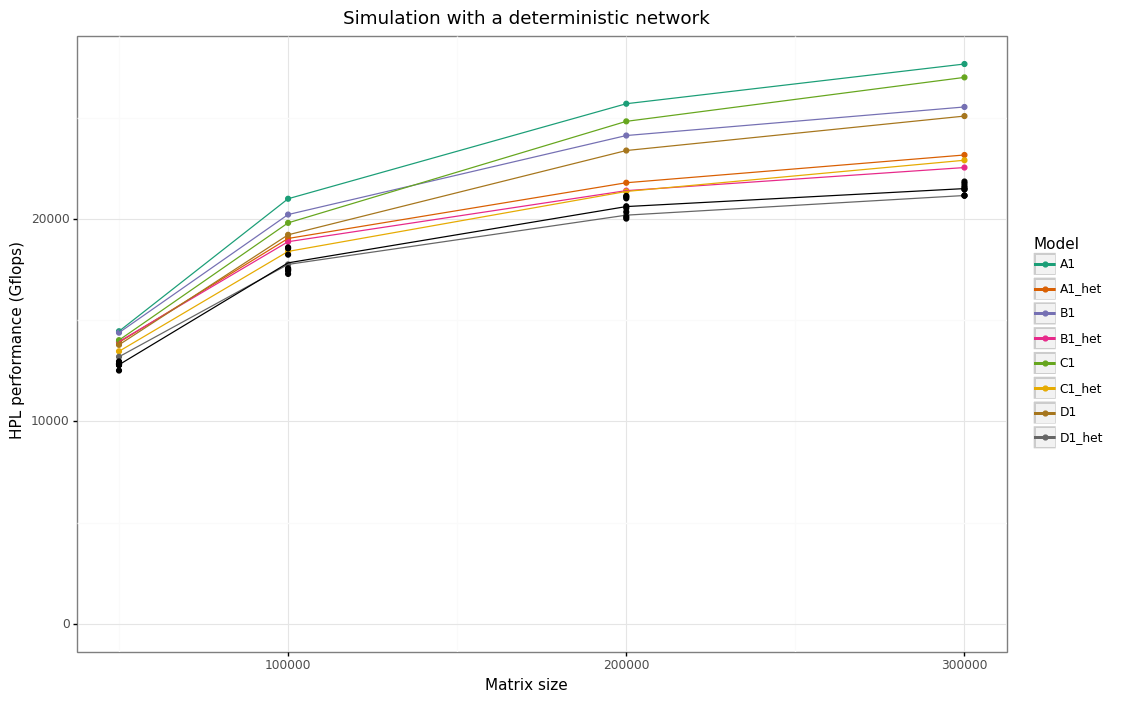

<ggplot: (8745888433149)>


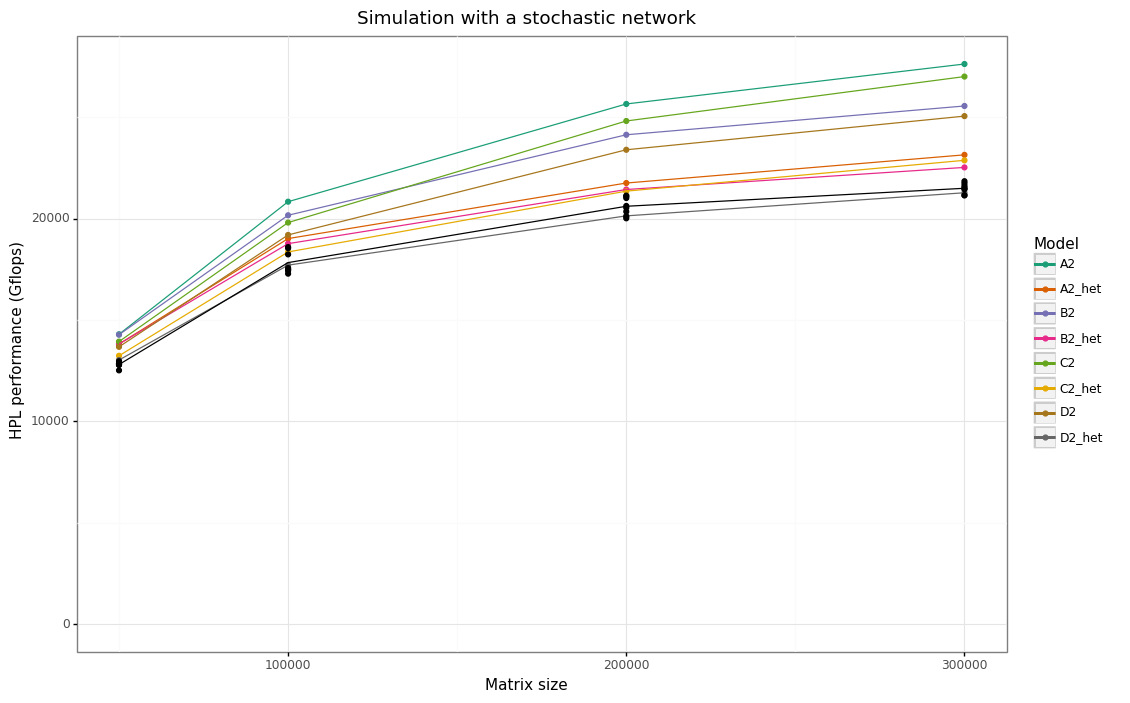

<ggplot: (-9223363290966389202)>


In [9]:
import numpy

def plot_perf(dfsim, dfreal):
    plot = ggplot(aes(x='matrix_size', y='gflops')) + theme_bw() + expand_limits(y=0)
    plot = plot + geom_point(dfsim, aes(color='model')) + geom_line(dfsim, aes(color='model'))
    plot = plot + geom_point(dfreal) +  stat_summary(dfreal, fun_y = numpy.mean, geom='line')
    plot = plot + scale_color_brewer(type='qual', palette='Dark2')
    plot = plot + xlab('Matrix size') + ylab('HPL performance (Gflops)') + labs(color='Model')
    return plot

print(plot_perf(dfsim[~dfsim['stochastic_network']], dfreal) + ggtitle('Simulation with a deterministic network'))
print(plot_perf(dfsim[dfsim['stochastic_network']], dfreal) + ggtitle('Simulation with a stochastic network'))

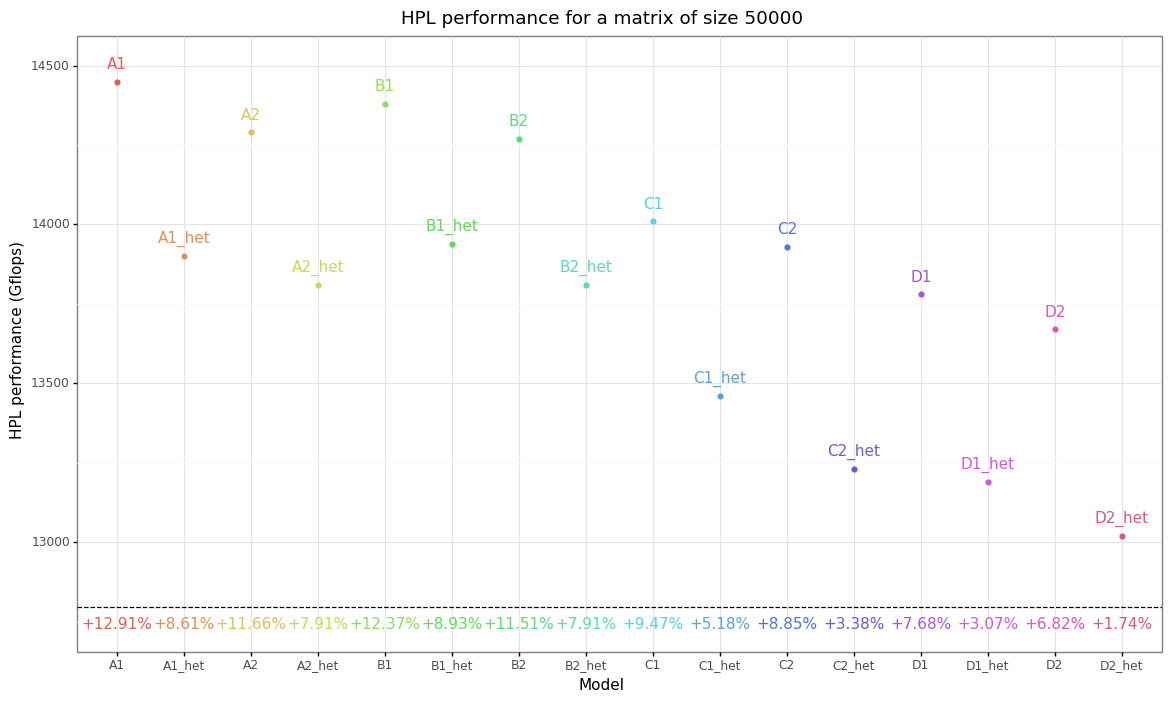

<ggplot: (8745887744972)>


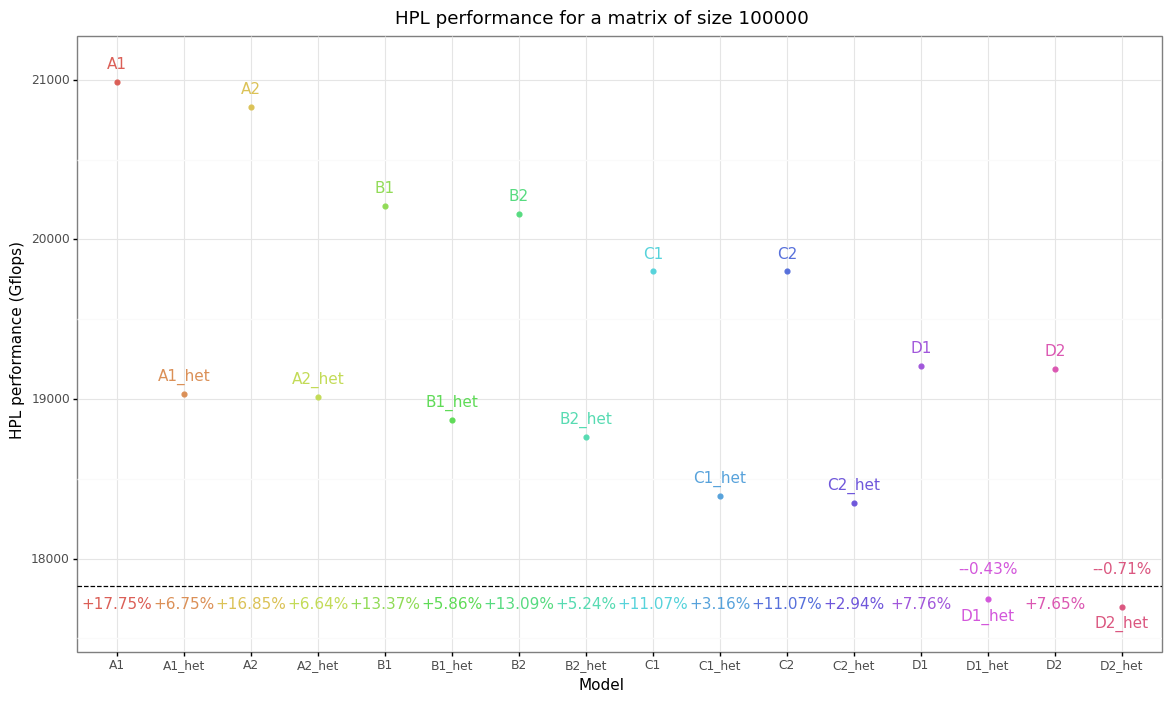

<ggplot: (-9223363290967055854)>


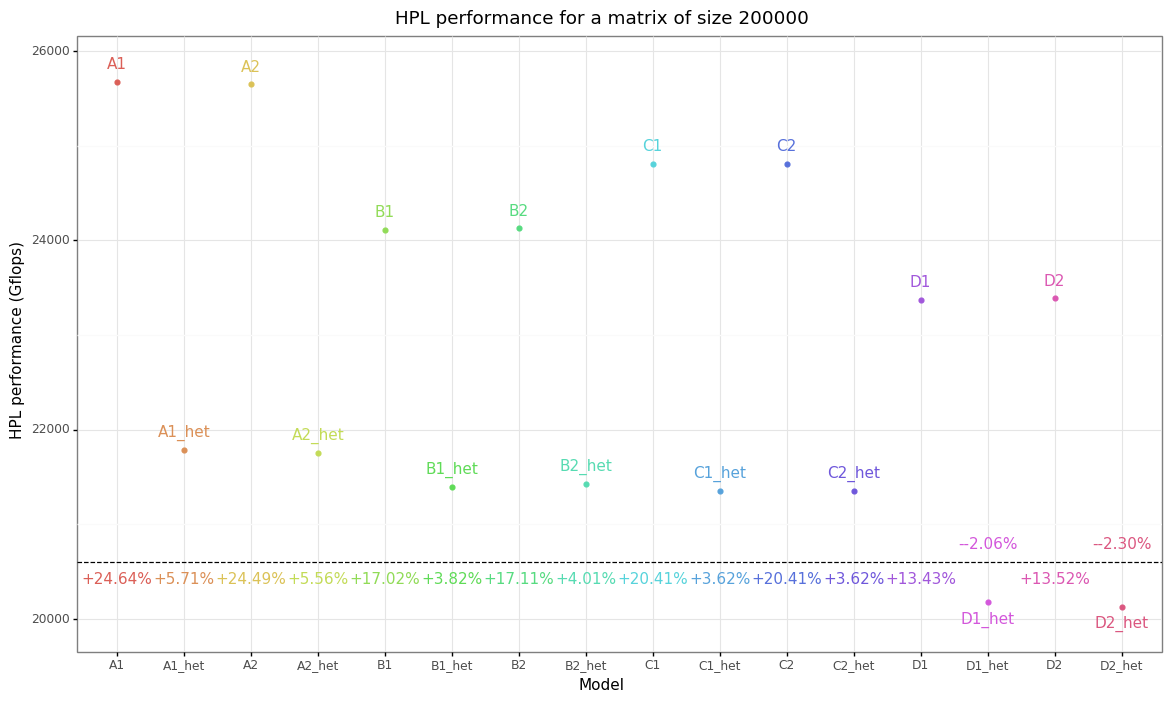

<ggplot: (-9223363291002698229)>


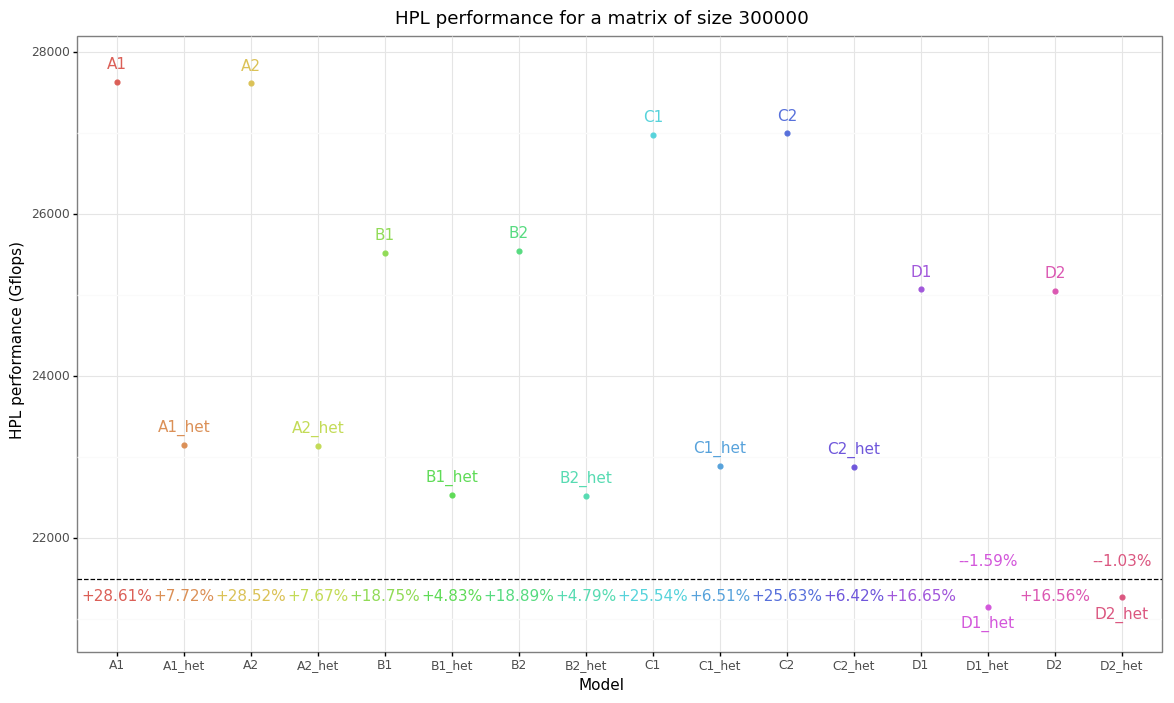

<ggplot: (-9223363291002692541)>


In [10]:
plotnine.options.figure_size = (14, 8)

def float_to_percent(x):
    sign = '+' if x > 0 else '-'
    return '%s%.2f%%' % (sign, x)

for size in sorted(dfsim['matrix_size'].unique()):
    reality = dfreal[dfreal['matrix_size'] == size]['gflops'].mean()
    plot = ggplot(aes(x='model', y='gflops', color='model')) + theme_bw()
    tmp = dfsim[dfsim['matrix_size'] == size].copy()
    tmp = tmp.groupby('model')[['gflops']].mean().reset_index()
    tmp['error'] = (tmp['gflops'] - reality)/reality*100
    plot = plot + geom_point(tmp) + ggtitle('HPL performance for a matrix of size %d' % (size))
    text = tmp.copy()
    delta = max(tmp['gflops'].max(), reality) - min(tmp['gflops'].min(), reality)
    text.loc[text.gflops > reality, 'gflops'] += delta/30
    text.loc[text.gflops <= reality, 'gflops'] -= delta/30
    plot = plot + geom_text(text, aes(label='model'))
    text2 = tmp.copy()
    text2['error_str'] = text2.apply(lambda row: float_to_percent(row['error']), axis=1)
    text2.loc[text2['error'] > 0, 'gflops'] = reality - delta/30
    text2.loc[text2['error'] <= 0, 'gflops'] = reality + delta/30
    plot = plot + geom_text(text2, aes(label='error_str'))
    plot = plot + geom_hline(yintercept=reality, linetype='dashed') + scale_color_discrete(guide=False) #scale_color_brewer(type='qual', palette='Dark2', guide=False)
    plot = plot + xlab('Model') + ylab('HPL performance (Gflops)')
    print(plot)